# Train own transformer model (Freeze Layers)


In [1]:
import pandas as pd

from sklearn import set_config
from sklearn.metrics import mean_squared_error
set_config(transform_output="pandas")

pd.set_option('mode.chained_assignment', None)
pd.options.display.max_rows = 1000

%matplotlib inline


def calc_metrics(submission, dtypes=["train", "test"]):
    result = {}
    for dtype in dtypes:
        name = f"MSE_{dtype}"
        mse = None
        sample = submission[submission["type"] == dtype]
        if not sample["rating"].isnull().all():
            mse = mean_squared_error(sample["rating"], sample["predict_rating"])

        result[name] = mse

    return result

In [2]:
# Your Name Surname
# !!! Please do not change the NAME in other hypotheses
NAME = "Belton_Manhica"
train_and_test = pd.read_csv(f"0_{NAME}.csv")

# split dataset for train and test part
train = train_and_test[train_and_test["type"] == "train"]
test = train_and_test[train_and_test["type"] == "test"]
train_and_test.shape, train.shape, test.shape

((10000, 3), (5000, 3), (5000, 3))

In [ ]:
train_and_test.sample(5)

,comment,rating,type
5913,This is a very easy game for kids . I would n'...,NaN,test
3711,"As a light 30 minute light-medium game , it 's...",6.0,train
1004,"Very fun , but felt like our group `` solved '...",5.0,train
5332,Great game . I was always wishing a board game...,NaN,test
786,"Excellent game , ( 1st ed ) components a littl...",8.0,train


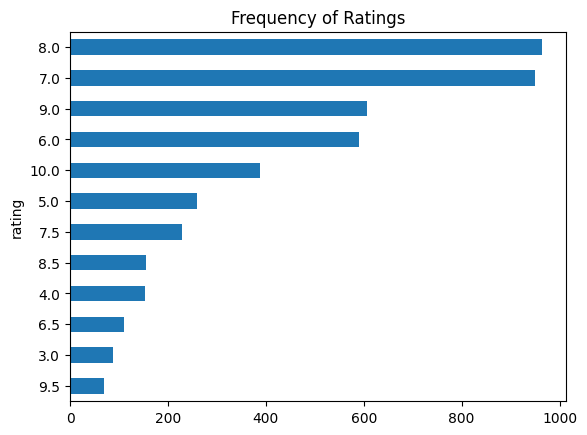

In [ ]:
#checking rating disctribution
import matplotlib.pyplot as plt

data_counts = train['rating'].value_counts(ascending = True)
data_counts[data_counts>50].plot.barh()
plt.title('Frequency of Ratings')
plt.show()

In [ ]:
#check the length of the longest comment
max(train['comment'].str.split().apply(len))

162

The longest comment has 162 words, this is less than the most model's contxt size (eg., for BERT it is 512). Hence, we do not not need to truncate out comments.   

side note: Usually, we truncate texts that are longer than the model's context size. Keep in mind that truncating texts can lead to loss of performance because important information can be lost.


In [3]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
from sklearn.model_selection import train_test_split


data_train, data_valid = train_test_split(train[train["type"] == "train"], test_size=0.1, random_state=42)

data_train.shape, data_valid.shape

((4500, 3), (500, 3))

In [5]:
def get_batch_list_ids(data, batch_size):
    return list(range(data.shape[0] // batch_size))

def get_batch_by_id(data, batch_size, idx):
    batch = data.iloc[batch_size * idx:batch_size * (idx + 1)]
    return batch["comment"].tolist(), batch["rating"].tolist()


BATCH_SIZE = 4

batch_ids = get_batch_list_ids(data_train, batch_size=BATCH_SIZE)
len(batch_ids)

1125

In [ ]:
texts, labels = get_batch_by_id(data_train, batch_size=BATCH_SIZE, idx=0)
len(texts), len(labels)

(4, 4)

In [ ]:
texts

['More fights and friendships are ruined by this game than any other . Watch friends quickly become enemies and throw things at each other . Watch spouses vow to divorce each other after playing . Great fun <UNK>',
 "Take possession of color-coded railroads between cities by gaining and spending cards . Easy game to understand , good for families . Relies quite heavily on luck though , both with the destinations you get and the Wagon Cards you can pick . Also , since the objectives are secret , it 's pretty much a solitaire game until another player is taking routes near the ones you 're trying to get and you have to adapt . Other than that , a pleasant experience",
 "Excellent game . Prefer to Caylus and some of the other heavier euros . Ca n't get it to table as I am the only one here who really enjoys it .",
 "If you 've got the time , and some good friends This game is wonderful . Interesting . Thematic . Space . Conquest . Perfection . Love strategy and sci-fi , this game is for y

In [ ]:
labels

[7.0, 6.54, 8.0, 8.0]

In [9]:
#transfor the data into Hugging face dataset
from datasets import Dataset

train_data = Dataset.from_pandas(data_train)
valid_data = Dataset.from_pandas(data_valid)
test_data = Dataset.from_pandas(test)

In [8]:
#check the data features
train_data

Dataset({
    features: ['comment', 'rating', 'type', '__index_level_0__'],
    num_rows: 4500
})

In [6]:
#tokenization
from transformers import AutoTokenizer, AutoModel

#select model
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

#initialize the all-MiniLM-L6-v2 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
#apply the tokenizer and print the first four batches

def tokenizerFunction(data):
  return tokenizer(data['comment'], padding =True, truncation = True)

tokenizerFunction(train_data[:4])

{'input_ids': [[101, 2062, 9590, 1998, 28956, 2024, 9868, 2011, 2023, 2208, 2084, 2151, 2060, 1012, 3422, 2814, 2855, 2468, 6716, 1998, 5466, 2477, 2012, 2169, 2060, 1012, 3422, 18591, 2015, 19076, 2000, 8179, 2169, 2060, 2044, 2652, 1012, 2307, 4569, 1026, 4895, 2243, 1028, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2202, 6664, 1997, 3609, 1011, 22402, 16197, 2090, 3655, 2011, 8550, 1998, 5938, 5329, 1012, 3733, 2208, 2000, 3305, 1010, 2204, 2005, 2945, 1012, 16803, 3243, 4600, 2006, 6735, 2295, 1010, 2119, 2007, 1996, 14345, 2017, 2131, 1998, 1996, 9540, 5329, 2017, 2064, 4060, 1012, 2036, 1010, 2144, 1996, 11100, 2024, 3595, 1010, 2009, 1005, 1055, 3492, 2172, 1037, 14017, 29422, 2208, 2127, 2178, 2447, 2003, 2635, 5847, 2379, 1996, 3924, 2017, 1005, 2128, 2667, 2000, 2131, 1998, 2017, 2031, 2000, 15581, 1012, 2060, 2084, 2008, 1010, 1037, 8242, 3325, 102], [101, 6581, 22

In [132]:
#create a class for the tokenization for the whole data

class MyDataset():
  def __init__(self, train_and_test, tokenizer, max_len = 128):
    self.comments = train_and_test['comment'].tolist()
    self.ratings = train_and_test['rating'].tolist()
    self.tokenizer = tokenizer
    self.max_len =  max_len

  def __len__(self):
    return len(self.comments)

  def __getitem__(self, idx):
    data_encoded = self.tokenizer(
        self.comments[idx],
        truncation = True,
        padding = 'max_length',
        max_length =self.max_len,
        return_tensors = 'pt'
    )

    rating = self.ratings[idx]
    rating = torch.tensor(0.0 if pd.isna(rating) else rating, dtype = torch.float)

    return {
            "input_ids": data_encoded["input_ids"].squeeze(0),
            "attention_mask": data_encoded["attention_mask"].squeeze(0),
            "rating": rating
        }


In [144]:
train_ds = MyDataset(data_train, tokenizer)
valid_ds = MyDataset(data_valid, tokenizer)
test_ds  = MyDataset(test, tokenizer)

In [145]:
#dataloaders
import torch
from torch.utils.data import Dataset, DataLoader

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE)

In [133]:
#check if there is a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Train the transformer model as feature extraction (freezing it's paramenters)

In [137]:
#Build the model (Freeze Transformer + Full connected layers)

class RatingModel(torch.nn.Module):
  def __init__(self, model_name):
    super().__init__()
    self.model = AutoModel.from_pretrained(model_name)

    #freeze model weights
    for p in self.model.parameters():
      p.requires_grad = False

    hidden_size = self.model.config.hidden_size
    self.fc = torch.nn.Linear(hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
    cls_emb = outputs.last_hidden_state[:, 0, :]
    logits = self.fc(cls_emb).squeeze(-1)
    logits = torch.clip(logits, min =0, max = 10)
    return logits


In [138]:
model = RatingModel(model_name).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-3)


In [139]:
EPOCHS = 3
train_losses, valid_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for batch in train_dl:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        targets = batch["rating"].to(device)

        optimizer.zero_grad()
        preds = model(input_ids, mask)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dl))

    # ---- validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valid_dl:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            targets = batch["rating"].to(device)

            preds = model(input_ids, mask)
            loss = criterion(preds, targets)
            val_loss += loss.item()

    valid_losses.append(val_loss / len(valid_dl))

    print(f"Epoch {epoch+1}/{EPOCHS} | Train={train_losses[-1]:.4f} | Valid={valid_losses[-1]:.4f}")


Epoch 1/3 | Train=3.3038 | Valid=2.9700
Epoch 2/3 | Train=2.8213 | Valid=2.8734
Epoch 3/3 | Train=2.7628 | Valid=2.8988


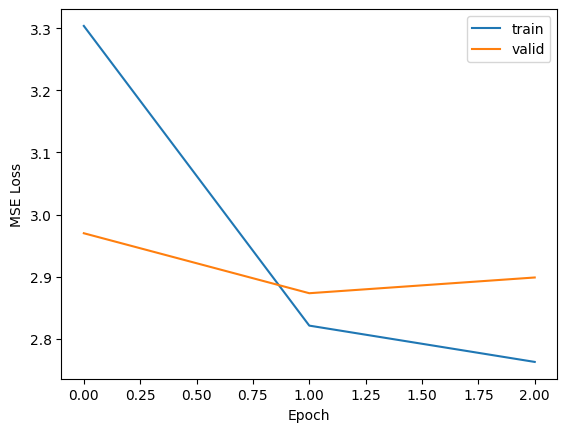

In [140]:
#plot the loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [146]:
def predict_dataset(dataset):
    preds = []
    model.eval()
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=BATCH_SIZE):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            out = model(ids, mask).cpu().numpy().tolist()
            preds.extend(out)
    return preds

In [149]:
len(test_ds)

5000

In [148]:
# Build predict_rating column in original order
preds_train = predict_dataset(train_ds)
preds_valid = predict_dataset(valid_ds)
preds_test  = predict_dataset(test_ds)

In [165]:
import numpy as np
preds_full = np.concatenate([np.array(preds_train), np.array(preds_valid), np.array(preds_test)])

In [166]:

train_and_test["predict_rating"] = preds_full
scores = calc_metrics(train_and_test)
print(scores)

{'MSE_train': 3.1716170151350496, 'MSE_test': None}


In [167]:
train_and_test.sample(5)

,comment,rating,type,predict_rating
9577,It 's a classic coop ( its biggest weakness be...,NaN,test,7.740524
4701,One of the best 2-player game ever ! Nice impl...,10.0,train,7.350027
9450,By far the most played game in my collection a...,NaN,test,7.588454
419,"Condition : Played , complete , box and game a...",8.0,train,7.503290
7172,"Good game , simple rules , but plenty of strat...",NaN,test,7.908922


# Final checks and prepare submission

In [168]:
if train_and_test.shape[0] != 10000:
    raise ValueError(f'Incorrect train_and_test file shape should be a 10000. {train_and_test.shape[0]} are given')

if "predict_rating" not in train_and_test.columns:
    raise ValueError(f'Column "predict_rating" should be in train_and_test dataset')

if train_and_test["predict_rating"].isnull().sum() > 0:
    raise ValueError(f'Column "predict_rating" have null values')

if (train_and_test["predict_rating"] < 0.).sum() > 0:
    raise ValueError(f'Column "predict_rating" contain negative values')

if (train_and_test["predict_rating"] > 10.).sum() > 0:
    raise ValueError(f'Column "predict_rating" contain values more than 10.')

train_and_test[["predict_rating"]].to_csv(f'3_{NAME}.csv', index=False)